# BFS Performance Benchmarking

This notebook benchmarks performance of running BFS within cuGraph against NetworkX. 

Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 10/30/2019
    
RAPIDS Versions: 0.10.0

Test Hardware

    GV100 32G, CUDA 10,0
    Intel(R) Core(TM) CPU i7-7800X @ 3.50GHz
    32GB system memory
    


### Test Data

| File Name              | Num of Vertices | Num of Edges |
|:---------------------- | --------------: | -----------: |
| preferentialAttachment |         100,000 |      999,970 |
| caidaRouterLevel       |         192,244 |    1,218,132 |
| coAuthorsDBLP          |         299,067 |    1,955,352 |
| dblp-2010              |         326,186 |    1,615,400 |
| citationCiteseer       |         268,495 |    2,313,294 |
| coPapersDBLP           |         540,486 |   30,491,458 |
| coPapersCiteseer       |         434,102 |   32,073,440 |
| as-Skitter             |       1,696,415 |   22,190,596 |




### Timing 
What is not timed:  Reading the data
What is timmed: (1) creating a Graph, (2) running BSF


## NOTICE
You must have run the dataPrep script prior to running this notebook so that the data is downloaded

See the README file in this folder for a discription of how to get the data

In [10]:
# Import needed libraries
import time
import cugraph
import cudf

In [11]:
# NetworkX libraries
import networkx as nx
from scipy.io import mmread

In [12]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

### Define the test data

In [13]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [14]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [15]:
# CuGraph PageRank

def cugraph_call(M, max_iter, tol, alpha):

    sources = cudf.Series(M.row)
    destinations = cudf.Series(M.col)
    
    print('\tcuGraph Solving... ')
    
    t1 = time.time()
        
    # cugraph Pagerank Call
    G = cugraph.Graph()
    G.add_edge_list(sources, destinations, None)    
    
    df = cugraph.bfs(G, 1)
    t2 = time.time() - t1
    
    return t2
    

In [16]:
# Basic NetworkX PageRank

def networkx_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}
        
    print('\tNetworkX Solving... ')
        
    # start timer
    t1 = time.time()
    
    Gnx = nx.DiGraph(M)

    pr = nx.bfs_edges(Gnx, 1)
    
    t2 = time.time() - t1

    return t2

### Run the benchmarks

In [17]:
# arrays to capture performance gains
perf_nx = []
names = []

for k,v in data.items():
    # Saved the file Name
    names.append(k)
    
    # read the data
    M = read_mtx_file(v)
    
    # call cuGraph - this will be the baseline
    trapids = cugraph_call(M, 100, 0.00001, 0.85)
    
    # Now call NetworkX
    tn = networkx_call(M, 100, 0.00001, 0.85)
    speedUp = (tn / trapids)
    perf_nx.append(speedUp)
    
    print("\tcuGraph (" + str(trapids) + ")  Nx (" + str(tn) + ")" )

Reading ./data/preferentialAttachment.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.010656595230102539)  Nx (5.156033277511597)
Reading ./data/caidaRouterLevel.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.008835792541503906)  Nx (6.3835508823394775)
Reading ./data/coAuthorsDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.014091253280639648)  Nx (11.634297847747803)
Reading ./data/dblp-2010.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.016170024871826172)  Nx (9.483900547027588)
Reading ./data/citationCiteseer.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.011234283447265625)  Nx (13.679563522338867)
Reading ./data/coPapersDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.056397438049316406)  Nx (156.52643752098083)
Reading ./data/coPapersCiteseer.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
cuGraph (0.06544947624206543)  Nx (159.71959853172302)
Reading ./data/as-Skitter.mtx...
	cuGraph Sol

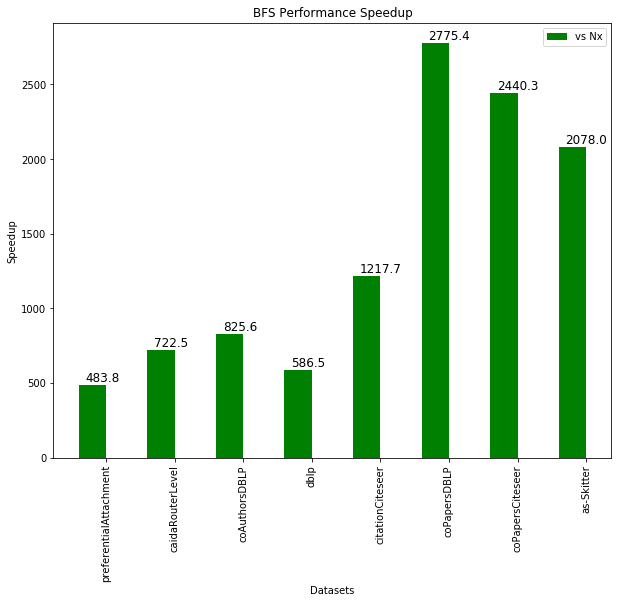

In [22]:
%matplotlib inline

plt.figure(figsize=(10,8))

bar_width = 0.4
index = np.arange(len(names))

_ = plt.bar(index, perf_nx, bar_width, color='g', label='vs Nx')

plt.xlabel('Datasets')
plt.ylabel('Speedup')
plt.title('BFS Performance Speedup')
plt.xticks(index + (bar_width / 2), names)
plt.xticks(rotation=90) 

# Text on the top of each barplot
for i in range(len(perf_nx)):
    plt.text(x = (i - .5) + bar_width, y = perf_nx[i] + 25, s = round(perf_nx[i], 1), size = 12)

plt.legend()
plt.show()